## Summary Plot of A Smart Meter Data Set

Downloads an indivisual sample file referenced on https://www.ckw.ch/lp/opendata.html .

In this case, we refer to one of the files indicated in data set "B", namely aggregated data per zip code.

1. Download an individual data file from data set "B" (aggregates by zip code).
2. Select an "interesting" zip code.
3. Performa data cleaning.
4. Display a summary plot showing aggregate smart meter data on e.g. a daily basis.

In [131]:
import pandas
def loadData(month : int = 202210) -> pandas.core.frame.DataFrame :
    url = "https://axsa4prod4publicdata4sa.blob.core.windows.net/$web/ckw_opendata_smartmeter_dataset_b_%i.csv.gz" % month
    return pandas.read_csv(url)

data = loadData()
data

,area_code,timestamp,num_meter,value_kwh
0,6016,2022-10-23T16:15:00.000Z,133,22.09575
1,6016,2022-10-02T10:30:00.000Z,132,15.41400
2,6016,2022-10-10T17:45:00.000Z,132,17.08600
3,6016,2022-10-09T07:45:00.000Z,132,15.86300
4,6016,2022-10-06T23:45:00.000Z,132,15.16100
...,...,...,...,...
259441,6283,2022-10-07T19:45:00.000Z,103,11.19700
259442,6283,2022-10-19T10:45:00.000Z,103,7.32200
259443,6283,2022-10-09T22:00:00.000Z,103,13.18000
259444,6283,2022-10-15T06:45:00.000Z,105,12.18300


Determine the zip codes with the highest turn over in kWh:

In [132]:
def getTopZipCodeByTurnover(data : pandas.core.frame.DataFrame = data) -> int :
    toByZip = data.groupby('area_code')['value_kwh'].sum()

    top10ZipCodes = toByZip.to_frame().sort_values(by = 'value_kwh', ascending=False).head(10)

    return top10ZipCodes.iloc[0].name

topZipCode = getTopZipCodeByTurnover()

topZipCode

6030

Time series for the top zip code:

In [133]:
def getDataByZipCode(zipCode : int = topZipCode) -> pandas.core.frame.DataFrame :
    return data.loc[data['area_code'] == topZipCode][["timestamp", "num_meter", "value_kwh"]]

topTs = getDataByZipCode()
topTs

,timestamp,num_meter,value_kwh
1102,2022-10-13T04:30:00.000Z,8101,791.185000
1103,2022-10-01T11:45:00.000Z,8105,918.221000
1104,2022-10-16T16:30:00.000Z,8099,937.900500
1105,2022-10-09T21:45:00.000Z,8101,748.174750
1106,2022-10-18T02:00:00.000Z,8100,706.878500
...,...,...,...
259226,2022-10-12T11:15:00.000Z,8101,704.556500
259227,2022-10-09T23:30:00.000Z,8101,1116.318500
259228,2022-10-21T18:30:00.000Z,8099,928.973321
259229,2022-10-22T09:45:00.000Z,8130,923.301750


Visual inspection of data quality by plotting distributions of
* number of meters counted,
* kWh metered.

<AxesSubplot: ylabel='Frequency'>

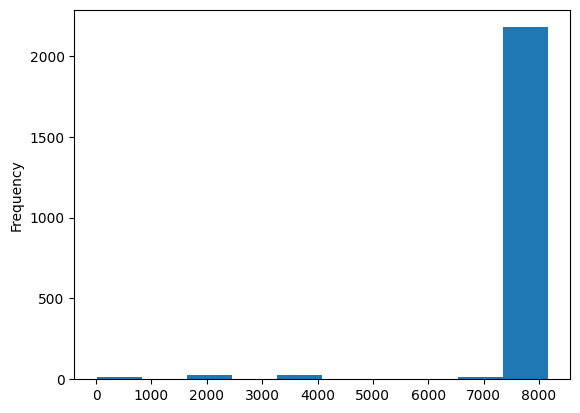

In [134]:
topTs['num_meter'].plot.hist(bins = 10)

<AxesSubplot: ylabel='Frequency'>

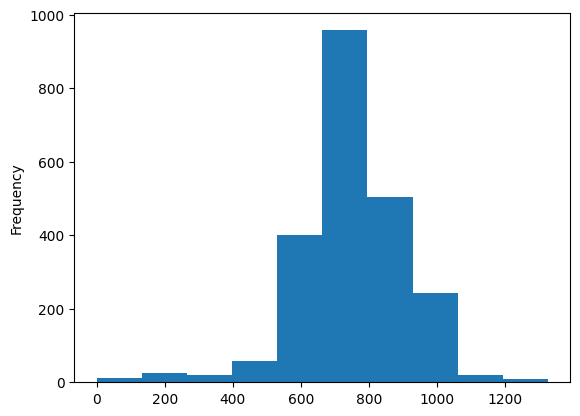

In [135]:
topTs['value_kwh'].plot.hist()

<AxesSubplot: xlabel='num_meter', ylabel='value_kwh'>

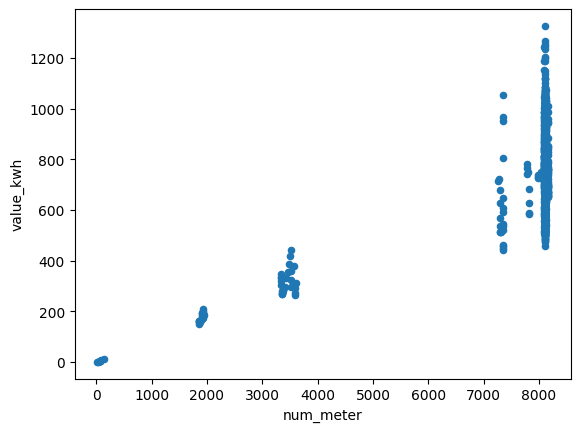

In [136]:
topTs.plot.scatter(x='num_meter', y='value_kwh')

We can visually observe a correlation between number of meters and kWh metered.
As a result, we try to de-noise by way of computing the average kWh / meter.

In [137]:
# Check the assumption that we have no samples with zero meters:
assert topTs.loc[data['num_meter'] == 0].size == 0
topTs['kWh_average'] = topTs['value_kwh'] / topTs['num_meter'] 

<AxesSubplot: ylabel='Frequency'>

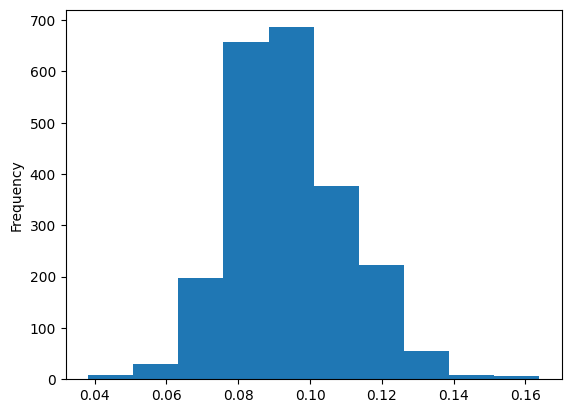

In [138]:
topTs['kWh_average'].plot.hist()

In [139]:
from datetime import datetime
def parseDateTimeString(timeStamp : str = '2022-10-13T04:30:00.000Z') -> datetime :
    return datetime.strptime(timeStamp, "%Y-%m-%dT%H:%M:%S.%f%z")

parseDateTimeString()
topTs['dateTime'] = topTs.timestamp.apply(parseDateTimeString)

We can plot at 15-minute resolution to get a feeling for average meter use.

<AxesSubplot: xlabel='dateTime'>

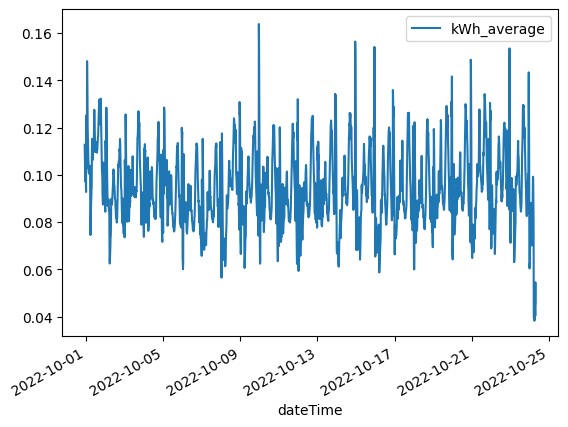

In [140]:
topTs.plot(x="dateTime", y=["kWh_average"])

In [141]:
def startOfDay(date : datetime = datetime.utcnow().date()) -> datetime :
    return datetime(date.year, date.month, date.day)
    
topTs['startOfDay'] = topTs.dateTime.apply(startOfDay)

<AxesSubplot: title={'center': 'Average kWh / Day'}, xlabel='startOfDay'>

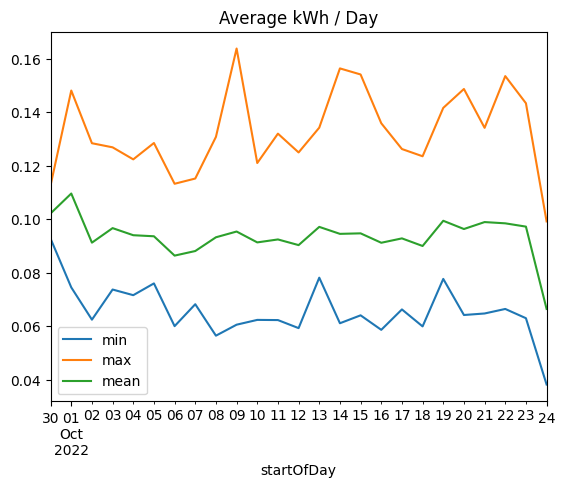

In [142]:
topTs[['startOfDay', 'kWh_average']].groupby("startOfDay").agg(['min', 'max', 'mean'])['kWh_average'].plot(title = 'Average kWh / Day')